In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn as nn

from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay

import os
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import wfdb

from tqdm import tqdm
import torchviz

import scipy

import h5py

import pickle

import torchsummary

#### Loss functions:

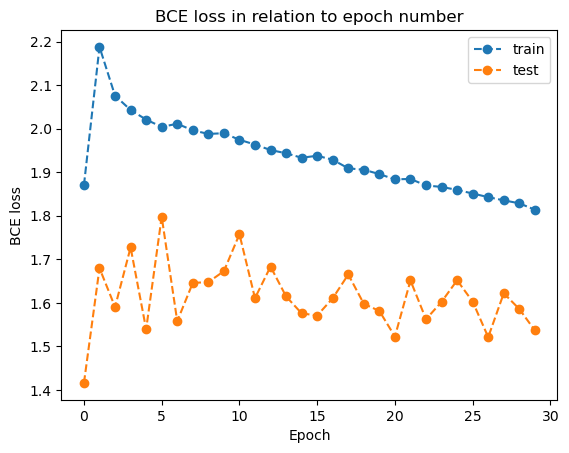

In [3]:
train_loss_vec = torch.load('train_loss_vec.pt', map_location=torch.device('cpu'))
test_loss_vec = torch.load('test_loss_vec.pt', map_location=torch.device('cpu'))

plt.figure()
plt.plot(train_loss_vec, 'o--', label='train')
plt.plot(test_loss_vec, 'o--', label='test')
plt.title("BCE loss in relation to epoch number")
plt.ylabel('BCE loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### Validation and performance metrics:

Function definitions:

In [4]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

calc_TN = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[0, 0]
calc_FP = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[0, 1]
calc_FN = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[1, 0]
calc_TP = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[1, 1]
def stats(y_test, y_pred_test):
    TN = calc_TN(y_test, y_pred_test)
    FP = calc_FP(y_test, y_pred_test)
    FN = calc_FN(y_test, y_pred_test)
    TP = calc_TP(y_test, y_pred_test)
    Se = TP/(TP+FN)
    Sp = TN/(TN+FP)
    PPV = TP/(TP+FP)
    NPV = TN/(TN+FN)
    Acc = (TP+TN)/(TP+TN+FP+FN)
    F1 = (2*Se*PPV)/(Se+PPV)
    return TN, FP, FN, TP, Se, Sp, PPV, NPV, Acc, F1

In [5]:
def validation(y_true, y_pred, y_ids):
    """
    Aggregates window-level predictions into sample-level predictions
    by averaging the top 50% scoring windows per sample.
    
    Args:
        y_true (Tensor): Tensor of shape (N,) with ground truth labels.
        y_pred (Tensor): Tensor of shape (N,) with predicted scores.
        y_ids (Tensor): Tensor of shape (N, 2), where each row uniquely identifies a sample.
        
    Returns:
        true_labels (dict): Mapping from sample ID to true label.
        final_scores (dict): Mapping from sample ID to aggregated prediction score.
    """
    from collections import defaultdict

    # Aggregate predictions and true labels by sample ID
    pred_samples_dict = defaultdict(list)
    true_samples_dict = {}

    for i in range(y_ids.shape[0]):
        y_id = f"{y_ids[i, 0].item()}_{y_ids[i, 1].item()}"
        pred_value = round(y_pred[i].item(), 4)  # round to 4 decimals
        pred_samples_dict[y_id].append(pred_value)
        
        if y_id not in true_samples_dict:
            true_samples_dict[y_id] = y_true[i].item()

    # Compute final prediction per sample using top 50% windows
    final_scores = {}
    for y_id, preds in pred_samples_dict.items():
        preds_sorted = sorted(preds, reverse=True)
        top_k = max(1, len(preds_sorted)//2)
        #top_k = max(1, len(preds_sorted))
        top_preds = preds_sorted[:top_k]
        avg_score = round(sum(top_preds) / len(top_preds), 4)  # also round final score
        final_scores[y_id] = avg_score

    return true_samples_dict, final_scores

In [6]:
def dicts_to_tensors(true_samples_dict, final_scores):
    # Ensure keys match
    common_keys = list(set(true_samples_dict.keys()) & set(final_scores.keys()))
    common_keys.sort()  # Optional: sort for reproducibility

    y_true_list = [true_samples_dict[k] for k in common_keys]
    y_pred_list = [final_scores[k] for k in common_keys]
    y_exams = [k for k in common_keys]

    y_true_tensor = torch.tensor(y_true_list, dtype=torch.float32)
    y_pred_tensor = torch.tensor(y_pred_list, dtype=torch.float32)

    return y_true_tensor, y_pred_tensor, y_exams

In [15]:
# Compute the Challenge score.
def compute_challenge_score(labels, outputs, fraction_capacity = 0.05, num_permutations = 10**4, seed=12345):
    # Check the data.
    assert len(labels) == len(outputs)
    num_instances = len(labels)
    capacity = int(fraction_capacity * num_instances)

    # Convert the data to NumPy arrays, as needed, for easier indexing.
    labels = np.asarray(labels, dtype=np.float64)
    outputs = np.asarray(outputs, dtype=np.float64)

    # Permute the labels and outputs so that we can approximate the expected confusion matrix for "tied" probabilities.
    tp = np.zeros(num_permutations)
    fp = np.zeros(num_permutations)
    fn = np.zeros(num_permutations)
    tn = np.zeros(num_permutations)

    if seed is not None:
        np.random.seed(seed)

    for i in range(num_permutations):
        permuted_idx = np.random.permutation(np.arange(num_instances))
        permuted_labels = labels[permuted_idx]
        permuted_outputs = outputs[permuted_idx]

        ordered_idx = np.argsort(permuted_outputs, stable=True)[::-1]
        ordered_labels = permuted_labels[ordered_idx]

        tp[i] = np.sum(ordered_labels[:capacity] == 1)
        fp[i] = np.sum(ordered_labels[:capacity] == 0)
        fn[i] = np.sum(ordered_labels[capacity:] == 1)
        tn[i] = np.sum(ordered_labels[capacity:] == 0)

    tp = np.mean(tp)
    fp = np.mean(fp)
    fn = np.mean(fn)
    tn = np.mean(tn)

    # Compute the true positive rate.
    if tp + fn > 0:
        tpr = tp / (tp + fn)
    else:
        tpr = float('nan')

    return tpr


Data loading and aggergating windows by sample:

In [7]:
y_true = torch.load('y_true.pt', map_location=torch.device('cpu'))
y_pred = torch.load('y_pred.pt', map_location=torch.device('cpu'))
y_ids = torch.load('y_ids.pt', map_location=torch.device('cpu'))

y_pred = torch.sigmoid(y_pred)

y_true_dict, y_pred_dict = validation(y_true, y_pred, y_ids)
y_true, y_pred, y_exams = dicts_to_tensors(y_true_dict, y_pred_dict)

Confidence level grouping:

In [12]:
strong_pos = y_pred >= 0.97
med_pos = (y_pred >= 0.94) * (y_pred < 0.97)
low_pos = (y_pred >= 0.92) * (y_pred < 0.94)

y_true_strong = y_true[strong_pos]
print("High confidence PPV: {0:.2f}".format(torch.sum(y_true_strong) / len(y_true_strong)))

y_true_med = y_true[med_pos]
print("Medium confidence PPV: {0:.2f}".format(torch.sum(y_true_med) / len(y_true_med)))

y_true_low = y_true[low_pos]
print("Medium confidence PPV: {0:.2f}".format(torch.sum(y_true_low) / len(y_true_low)))

High confidence PPV: 0.36
Medium confidence PPV: 0.31
Medium confidence PPV: 0.16


Confusion matrix and performance statistics:

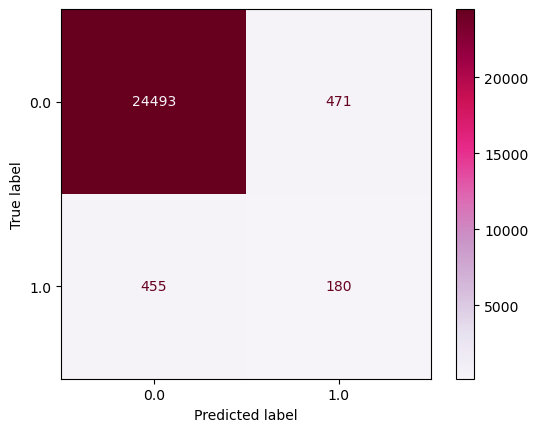

In [13]:
sigmoid_threshold = 0.92

y_pred_proba = y_pred.cpu().detach()
y_pred_label = (y_pred.cpu().detach()>sigmoid_threshold)*1
y_true_label = y_true.cpu()

ConfusionMatrixDisplay.from_predictions(y_true_label, y_pred_label, cmap='PuRd')
plt.title("")
plt.show()

In [14]:
TN, FP, FN, TP, Se, Sp, PPV, NPV, Acc, F1 = stats(y_true_label, y_pred_label)
print("Performance metrics:")
print('Sensitivity is {:.4f}. \nSpecificity is {:.4f}. \nPPV is {:.2f}. \nNPV is {:.4f}. \nAccuracy is {:.4f}. \nF1 is {:.4f}. '.format(Se,Sp,PPV,NPV,Acc,F1))
mcc = ((TP * TN) - (FP * FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
print('MCC is {:.4f}.'.format(mcc))
print('AUROC is {:.4f}.'.format(roc_auc_score(y_true_label, y_pred_proba)))

Performance metrics:
Sensitivity is 0.2835. 
Specificity is 0.9811. 
PPV is 0.28. 
NPV is 0.9818. 
Accuracy is 0.9638. 
F1 is 0.2799. 
MCC is 0.2614.
AUROC is 0.8300.


Challenge score:

In [16]:
compute_challenge_score(y_true, y_pred)

np.float64(0.3921259842519685)

#### Domain classification accuracy:

In [19]:
import torch
import torch.nn.functional as F

# Load your tensors
domain_true = torch.load('domain_true.pt', map_location=torch.device('cpu'))
domain_pred_logits = torch.load('domain_pred.pt', map_location=torch.device('cpu'))

# 1. Get the predicted domain IDs (0, 1, or 2)
# Use argmax directly on the logits for CrossEntropyLoss output
domain_pred_ids = torch.argmax(domain_pred_logits, dim=1)

print(f"Shape of domain_true: {domain_true.shape}")
print(f"Shape of domain_pred_logits: {domain_pred_logits.shape}")
print(f"Shape of domain_pred_ids: {domain_pred_ids.shape}")

# Example: Count of predicted domain 1 (PTB-XL)
print(f"Number of samples predicted as domain 1 (PTB-XL): {torch.sum(domain_pred_ids == 1).item()}")


# Calculate accuracy for each domain
domain_labels = ['code15', 'ptbxl', 'sami']
domain_ids_map = {'code15': 0, 'ptbxl': 1, 'sami': 2}

for domain_name, domain_id in domain_ids_map.items():
    # Create a mask for samples that *actually belong* to this domain
    actual_domain_mask = (domain_true == domain_id)

    # Filter the true and predicted labels for only this domain's samples
    true_labels_for_this_domain = domain_true[actual_domain_mask]
    predicted_labels_for_this_domain = domain_pred_ids[actual_domain_mask]

    # Calculate correct predictions within this domain
    correct_predictions = (true_labels_for_this_domain == predicted_labels_for_this_domain)

    # Calculate accuracy
    num_samples_in_domain = len(true_labels_for_this_domain)

    if num_samples_in_domain > 0:
        accuracy = torch.sum(correct_predictions).item() / num_samples_in_domain
        print(f"Accuracy for {domain_name} (Domain ID {domain_id}): {accuracy:.4f} "
              f"({torch.sum(correct_predictions).item()}/{num_samples_in_domain} correct)")
    else:
        print(f"No samples found for {domain_name} (Domain ID {domain_id}) in the loaded data.")

# Overall accuracy (optional, but good for sanity check)
overall_correct_predictions = (domain_true == domain_pred_ids)
overall_accuracy = torch.sum(overall_correct_predictions).item() / len(domain_true)
print(f"\nOverall Domain Classification Accuracy: {overall_accuracy:.4f}")

Shape of domain_true: torch.Size([162206])
Shape of domain_pred_logits: torch.Size([162206, 3])
Shape of domain_pred_ids: torch.Size([162206])
Number of samples predicted as domain 1 (PTB-XL): 65473
Accuracy for code15 (Domain ID 0): 0.2990 (43818/146551 correct)
Accuracy for ptbxl (Domain ID 1): 0.3206 (4870/15192 correct)
Accuracy for sami (Domain ID 2): 0.4881 (226/463 correct)

Overall Domain Classification Accuracy: 0.3016


#### t-SNE plots: